Here we want to build a model. We decide on building an LSTM for the following reasons: 
- Need to capture long-term information in the model.
- Other model choices would not be appropriate (due to non-staionary time series).
- Complexity of time series can be properly captured.

We will first build a model for all states, then build a model per state.

In [7]:
import datetime
import pickle
import polars as pl
import ml_utils
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error
import constants
import numpy as np

In [8]:
with open("df_all.pkl", "rb") as file:
    df_all = pickle.load(file)

In [9]:
df_all = df_all.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

df_all.head(8)

date,a,b,o,ab,all,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,weekday,month,day_of_year
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,i8,i8,i16
2006-01-01,152,139,194,40,525,0,0,0,0,7,1,1
2006-01-02,53,43,112,19,227,0,0,0,0,1,1,2
2006-01-03,29,21,56,6,112,0,0,0,0,2,1,3
2006-01-04,92,98,165,36,391,0,0,0,0,3,1,4
2006-01-05,149,198,193,42,582,0,0,0,0,4,1,5
2006-01-06,94,77,126,27,324,0,0,0,0,5,1,6
2006-01-07,29,28,48,13,118,0,0,0,0,6,1,7
2006-01-08,218,212,314,51,795,0,0,0,0,7,1,8


In [10]:
for lag in range(1, constants.WINDOW_SIZE+1):
    df_all = df_all.with_columns(
        pl.col("all").shift(lag).alias(f"all_lag_{lag}")
    )

df_all = df_all.drop_nulls()

In [11]:
df_all

date,a,b,o,ab,all,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,weekday,month,day_of_year,all_lag_1,all_lag_2,all_lag_3,all_lag_4,all_lag_5,all_lag_6,all_lag_7
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,i8,i8,i16,i64,i64,i64,i64,i64,i64,i64
2006-01-08,218,212,314,51,795,0,0,0,0,7,1,8,118,324,582,391,112,227,525
2006-01-09,83,95,151,17,346,0,0,0,0,1,1,9,795,118,324,582,391,112,227
2006-01-10,1,0,1,0,2,0,0,1,0,2,1,10,346,795,118,324,582,391,112
2006-01-11,128,111,179,30,448,0,0,0,0,3,1,11,2,346,795,118,324,582,391
2006-01-12,211,236,316,42,805,0,0,0,0,4,1,12,448,2,346,795,118,324,582
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-05-21,375,420,638,81,1514,0,0,0,0,3,5,141,1843,765,3232,2400,884,1547,1686
2025-05-22,394,467,660,105,1626,0,0,0,0,4,5,142,1514,1843,765,3232,2400,884,1547
2025-05-23,230,300,403,60,993,0,0,0,0,5,5,143,1626,1514,1843,765,3232,2400,884


In [12]:
X_seq = df_all.select([f"all_lag_{lag}" for lag in range(1, constants.WINDOW_SIZE+1)]).to_numpy().reshape(-1, constants.WINDOW_SIZE, 1)
X_features = df_all.select(["weekday", "month", "day_of_year", "is_religion_or_culture_holiday", "is_other_holiday", "is_low_donation_holiday", "is_high_donation_holiday"]).to_numpy()
y = df_all['all'].to_numpy()

In [13]:
# Set up scalers 
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
X_scaler = StandardScaler()

In [14]:
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
X_features_scaled = X_scaler.fit_transform(X_features)
X_seq_scaled = y_scaler.transform(X_seq.reshape(-1, 1)).reshape(-1, constants.WINDOW_SIZE, 1)

In [15]:
with open('x_scaler.pkl', 'wb') as file:
    pickle.dump(X_scaler, file)
    
with open('y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)

In [16]:
X_seq_train, X_seq_val, X_seq_test, X_features_train, X_features_val, X_features_test, y_train, y_val, y_test = ml_utils.train_val_split_lstm_feature_data(
    X_seq_scaled,
    X_features_scaled,
    y_scaled,
    constants.TRAIN_FRAC,
    constants.VAL_FRAC
)

In [17]:
experiment_id = ml_utils.get_or_create_mlflow_experiment(f"MY_blood_donations_{datetime.datetime.now().strftime("%Y%m%d")}")

In [18]:
model_type = ["LSTM", "SimpleRNN"]
seq_units = [12, 24, 48]
dense_units = [4, 12]
activation_list = ['sigmoid', 'relu']
optimizer_list = ['adam', 'rmsprop']
dropout_list = [0.05, 0.1]

In [ ]:
for seq_type in model_type:
    for seq_unit in seq_units:
        for dense_unit in dense_units:
            for activation in activation_list:
                for optimizer in optimizer_list:
                    for dropout in dropout_list:
                        print(f"Running {seq_type} experiment with seq_units={seq_unit}, dense_units={dense_unit}, activation={activation}, optimizer={optimizer}, dropout={dropout}.")
                        ml_utils.run_experiment(
                            X_seq_train=X_seq_train, X_features_train=X_features_train, y_train=y_train,
                            X_seq_val=X_seq_val, X_features_val=X_features_val, y_val=y_val,
                            seq_type=seq_type, seq_units=seq_unit, dense_units=dense_unit, activation=activation, dropout=dropout,
                            optimizer=optimizer, experiment_id=experiment_id
                        )

Running LSTM experiment with seq_units=12, dense_units=4, activation=sigmoid, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3007 - mae: 0.3759
Validation Loss: 0.3215460479259491, Validation MAE: 0.4005095362663269
Running LSTM experiment with seq_units=12, dense_units=4, activation=sigmoid, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2985 - mae: 0.3712
Validation Loss: 0.3246289789676666, Validation MAE: 0.3987874388694763
Running LSTM experiment with seq_units=12, dense_units=4, activation=sigmoid, optimizer=rmsprop, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3029 - mae: 0.3744 
Validation Loss: 0.3294394016265869, Validation MAE: 0.3986733555793762
Running LSTM experiment with seq_units=12, dense_units=4, activation=sigmoid, optimizer=rmsprop, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3553 - mae: 0.4052
Validation Loss: 0.3745464086532593, Validation MAE: 0.4304862320423126
Running LSTM experiment with seq_units=12, dense_units=4, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2870 - mae: 0.3708
Validation Loss: 0.3003309965133667, Validation MAE: 0.38226017355918884
Running LSTM experiment with seq_units=12, dense_units=4, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2682 - mae: 0.3518
Validation Loss: 0.29522645473480225, Validation MAE: 0.3742135465145111
Running LSTM experiment with seq_units=12, dense_units=4, activation=relu, optimizer=rmsprop, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3181 - mae: 0.3633
Validation Loss: 0.3426038920879364, Validation MAE: 0.3823871910572052
Running LSTM experiment with seq_units=12, dense_units=4, activation=relu, optimizer=rmsprop, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3244 - mae: 0.3851
Validation Loss: 0.3616935908794403, Validation MAE: 0.4094376266002655
Running LSTM experiment with seq_units=12, dense_units=12, activation=sigmoid, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2865 - mae: 0.3641
Validation Loss: 0.3078696131706238, Validation MAE: 0.3887881934642792
Running LSTM experiment with seq_units=12, dense_units=12, activation=sigmoid, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2929 - mae: 0.3689
Validation Loss: 0.3143049478530884, Validation MAE: 0.3939761817455292
Running LSTM experiment with seq_units=12, dense_units=12, activation=sigmoid, optimizer=rmsprop, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3152 - mae: 0.3855
Validation Loss: 0.3374493718147278, Validation MAE: 0.40834733843803406
Running LSTM experiment with seq_units=12, dense_units=12, activation=sigmoid, optimizer=rmsprop, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3302 - mae: 0.3949
Validation Loss: 0.3530607521533966, Validation MAE: 0.41820287704467773
Running LSTM experiment with seq_units=12, dense_units=12, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2530 - mae: 0.3492
Validation Loss: 0.2641415297985077, Validation MAE: 0.358749657869339
Running LSTM experiment with seq_units=12, dense_units=12, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2491 - mae: 0.3416
Validation Loss: 0.27180373668670654, Validation MAE: 0.36506304144859314
Running LSTM experiment with seq_units=12, dense_units=12, activation=relu, optimizer=rmsprop, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2647 - mae: 0.3516
Validation Loss: 0.2888126075267792, Validation MAE: 0.3756345212459564
Running LSTM experiment with seq_units=12, dense_units=12, activation=relu, optimizer=rmsprop, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2883 - mae: 0.3746
Validation Loss: 0.3014935255050659, Validation MAE: 0.3944494128227234
Running LSTM experiment with seq_units=24, dense_units=4, activation=sigmoid, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2688 - mae: 0.3547
Validation Loss: 0.29510924220085144, Validation MAE: 0.37809664011001587
Running LSTM experiment with seq_units=24, dense_units=4, activation=sigmoid, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2973 - mae: 0.3691
Validation Loss: 0.3294757604598999, Validation MAE: 0.3979965150356293
Running LSTM experiment with seq_units=24, dense_units=4, activation=sigmoid, optimizer=rmsprop, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2910 - mae: 0.3676
Validation Loss: 0.31703466176986694, Validation MAE: 0.3900349736213684
Running LSTM experiment with seq_units=24, dense_units=4, activation=sigmoid, optimizer=rmsprop, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3085 - mae: 0.3776
Validation Loss: 0.34064173698425293, Validation MAE: 0.4036378264427185
Running LSTM experiment with seq_units=24, dense_units=4, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2668 - mae: 0.3635
Validation Loss: 0.28055405616760254, Validation MAE: 0.3730691373348236
Running LSTM experiment with seq_units=24, dense_units=4, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2774 - mae: 0.3558
Validation Loss: 0.29754960536956787, Validation MAE: 0.37790000438690186
Running LSTM experiment with seq_units=24, dense_units=4, activation=relu, optimizer=rmsprop, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2470 - mae: 0.3480
Validation Loss: 0.26855531334877014, Validation MAE: 0.36321157217025757
Running LSTM experiment with seq_units=24, dense_units=4, activation=relu, optimizer=rmsprop, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2813 - mae: 0.3675
Validation Loss: 0.2989409267902374, Validation MAE: 0.3880051374435425
Running LSTM experiment with seq_units=24, dense_units=12, activation=sigmoid, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2616 - mae: 0.3511
Validation Loss: 0.29107770323753357, Validation MAE: 0.3742143511772156
Running LSTM experiment with seq_units=24, dense_units=12, activation=sigmoid, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2847 - mae: 0.3597
Validation Loss: 0.3079766631126404, Validation MAE: 0.3841480314731598
Running LSTM experiment with seq_units=24, dense_units=12, activation=sigmoid, optimizer=rmsprop, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3058 - mae: 0.3680
Validation Loss: 0.3306974768638611, Validation MAE: 0.39256539940834045
Running LSTM experiment with seq_units=24, dense_units=12, activation=sigmoid, optimizer=rmsprop, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2959 - mae: 0.3705
Validation Loss: 0.3201598525047302, Validation MAE: 0.393310546875
Running LSTM experiment with seq_units=24, dense_units=12, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2386 - mae: 0.3358
Validation Loss: 0.25168824195861816, Validation MAE: 0.34918197989463806
Running LSTM experiment with seq_units=24, dense_units=12, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2682 - mae: 0.3520
Validation Loss: 0.28288882970809937, Validation MAE: 0.36970436573028564
Running LSTM experiment with seq_units=24, dense_units=12, activation=relu, optimizer=rmsprop, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2440 - mae: 0.3435
Validation Loss: 0.2581125497817993, Validation MAE: 0.3609837293624878
Running LSTM experiment with seq_units=24, dense_units=12, activation=relu, optimizer=rmsprop, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2544 - mae: 0.3406
Validation Loss: 0.2711538076400757, Validation MAE: 0.3616622984409332
Running LSTM experiment with seq_units=48, dense_units=4, activation=sigmoid, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2652 - mae: 0.3518
Validation Loss: 0.29764315485954285, Validation MAE: 0.3756266236305237
Running LSTM experiment with seq_units=48, dense_units=4, activation=sigmoid, optimizer=adam, dropout=0.1.


In [ ]:
model = ml_utils.get_best_model(experiment_id, "metrics.val_loss")

In [ ]:
y_pred = y_scaler.inverse_transform(model.predict([X_seq_test, X_features_test]))
y_test_scaled = y_scaler.inverse_transform(y_test.reshape(-1, 1))
mean_absolute_error(y_test_scaled, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


259.36250266491527

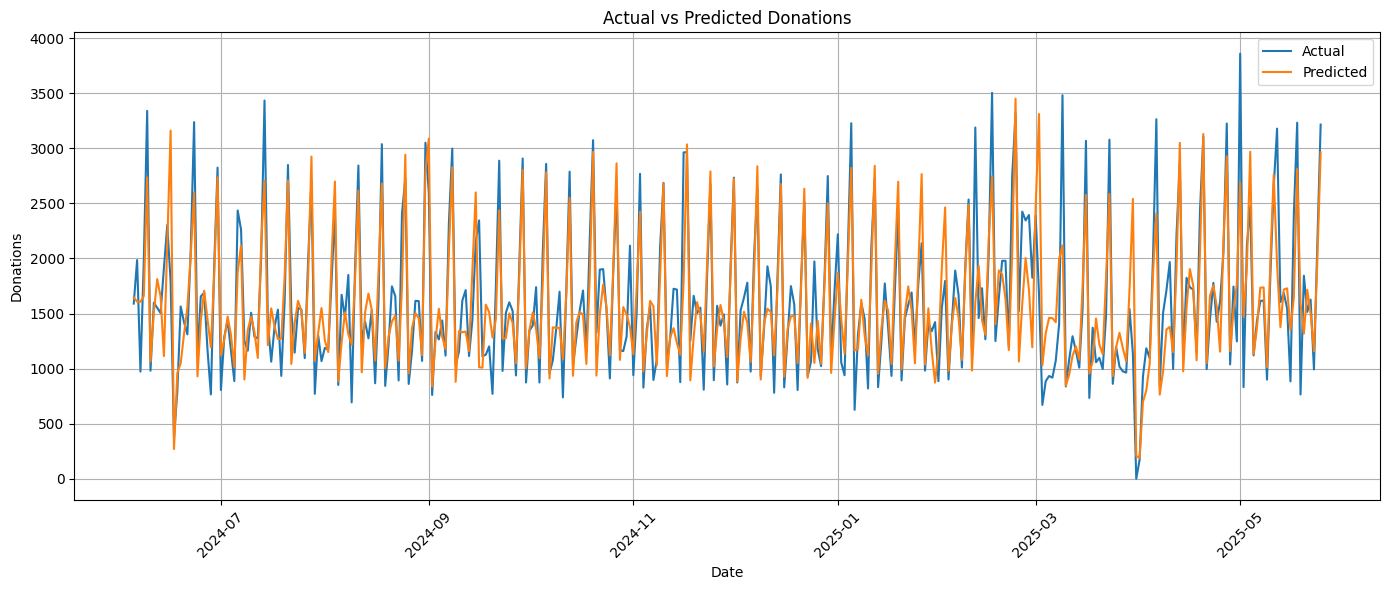

y_true,y_pred,diff,date,abs_diff
f64,f32,f64,date,f64
1674.0,3311.0,-1637.0,2025-03-02,1637.0
3188.0,1601.0,1587.0,2025-02-11,1587.0
1136.0,2540.0,-1404.0,2025-03-30,1404.0
1789.0,3160.0,-1371.0,2024-06-16,1371.0
3481.0,2119.0,1362.0,2025-03-09,1362.0
…,…,…,…,…
1345.0,1349.0,-4.0,2024-10-01,4.0
1280.0,1284.0,-4.0,2024-11-12,4.0
1196.0,1194.0,2.0,2025-03-25,2.0


In [ ]:
pred_df = pl.DataFrame({'y_true': y_test_scaled.flatten(), 'y_pred': np.round(y_pred).flatten()})

pred_df = pred_df.with_columns(
    (pl.col('y_true') - pl.col('y_pred')).alias('diff')
).with_columns(
    pl.Series("date", df_all[-pred_df.height:]["date"])
)

pred_df = pred_df.with_columns(
    (abs(pl.col('diff')).alias('abs_diff'))
)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pred_df["date"], pred_df["y_true"], label="Actual")
plt.plot(pred_df["date"], pred_df["y_pred"], label="Predicted")
plt.title("Actual vs Predicted Donations")
plt.xlabel("Date")
plt.ylabel("Donations")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pred_df.sort(by='abs_diff', descending=True)

In [ ]:
pred_df['y_true'].mean()

1620.5352112676057

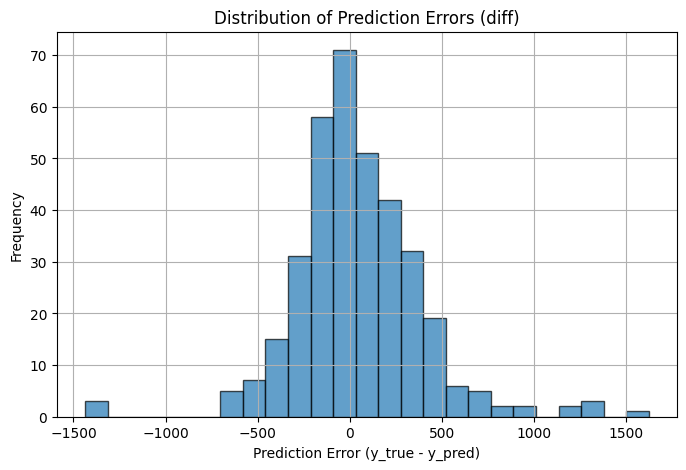

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(pred_df["diff"], bins=25, edgecolor='k', alpha=0.7)
plt.title("Distribution of Prediction Errors (diff)")
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()